### Step1 - 导入相关包 & 初始化设置

In [1]:
import os, sys
import datetime

from langchain.agents import create_agent
from langchain.chat_models import init_chat_model
from langchain.tools import tool
# 常用的消息类型
from langchain.messages import HumanMessage, SystemMessage, ToolMessage, AIMessage, AIMessageChunk

# Human in the loop 需要借助中间件来实现
from langchain.agents.middleware import HumanInTheLoopMiddleware
from langgraph.types import Command
from langgraph.checkpoint.memory import InMemorySaver

# 默读取当前目录下的 .env 文件, 可以通过 dotenv_path 来修改
from dotenv import load_dotenv
root_dir = os.path.dirname(os.getcwd())
load_dotenv(dotenv_path=os.path.join(root_dir, ".env"))

# 记录日志
from loguru import logger
logger.remove()
logger.add(sys.stderr, level=os.getenv("LOG_LEVEL"))

# Human in the loop 需要使用 checkpointer 来保存状态
checkpointer = InMemorySaver()

### Step2 - 定义工具

In [2]:
# 直接定义函数 (@tool 实际上可以不加, LangChain 会自动添加)
@tool
def get_offset_datetime_and_weekday(offset_day: int) -> dict[str, str]:
    """
    获取指定时间和星期, 如果 offset_day 为 0, 则结果为当前时间
    
    Args:
        offset_day: 基于当前时间为准的偏移天数, 类型为 int, 可以为负数
    """
    # 当前时间
    current_date = datetime.datetime.now()
    # 计算偏移后的时间
    target_date = current_date + datetime.timedelta(days=offset_day)
    # 格式化时间 / 星期
    formated_now = target_date.strftime("%Y-%m-%d %H:%M:%S")
    full_weekday = target_date.strftime("%A")

    return {"target_date": formated_now, "weekday": full_weekday}


### Step3 - 创建 Agent 智能体

In [3]:
# 创建 ChatModel: v1 创建聊天模型的方法
chat_model = init_chat_model(
    model_provider="ollama",
    # model 也可以写为 <model_provider>:<model_name> 的形式
    # 这样就可以不用指定 model_provider 这个参数了
    model = os.getenv("OLLAMA_LLM_MODEL"),
    base_url = os.getenv("OLLAMA_BASE_URL"),
    max_tokens = 4096,
)
chat_model

ChatOllama(model='qwen3:4b-instruct', base_url='http://localhost:11434')

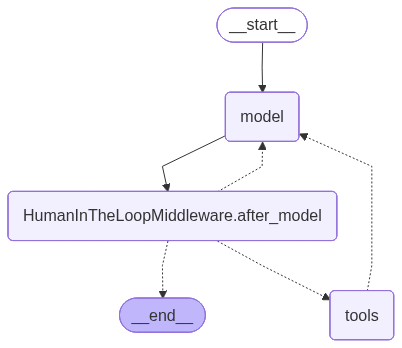

In [4]:
# 系统提示词
system_prompt="""
你是一个专业的AI助手, 请用简洁的方式回复用户的问题.
你拥有一个工具 get_offset_datetime_and_weekday 可以用来获取指定的时间.
"""
# 创建 Agent
agent = create_agent(
    model=chat_model,
    # 提示词可以不写, 这样也可以在调用时用 SystemMessage 来指定
    system_prompt=system_prompt,
    # 指定 checkpointer
    checkpointer=checkpointer,
    # 绑定工具
    tools=[get_offset_datetime_and_weekday],
    # 绑定中间件
    middleware=[
        # https://docs.langchain.com/oss/python/langchain/human-in-the-loop#configuration-options
        HumanInTheLoopMiddleware(
            interrupt_on={
                # False 为自动批准, True 或 InterruptOnConfig 对象 才会执行中断
                # <function_name>: bool | InterruptOnConfig
                "get_offset_datetime_and_weekday": {"allowed_decisions": ["approve", "reject", "edit"]},
            },
            # 动作请求描述的前缀
            # 如果不写默认值为 Tool execution requires approval
            description_prefix="工具执行挂起等待决策：",
        ),
    ]
)
agent

### Step4 - 调用智能体

In [ ]:
# 第一轮问答
response = agent.invoke(
    {"messages": [{"role": "user", "content": "昨天是星期几?"}]},
    # 利用 configurable 来隔离不同的对话
    config={"configurable": {"thread_id": "1"}},
)

for message in response["messages"]:
    message.pretty_print()

logger.debug(response)

if '__interrupt__' in response:
    # 用 .value 可以获取 Interrupt 对象的值
    logger.warning(response["__interrupt__"][0])


# 情况1: 同意
response = agent.invoke(
    Command(
        resume={"decisions": [{"type": "approve"}]},
    ),
    # 利用 configurable 来隔离不同的对话
    config={"configurable": {"thread_id": "1"}},
)

for message in response["messages"]:
    message.pretty_print()

2025-12-07 16:16:29.985 | DEBUG    | __main__:<module>:10 - {'messages': [HumanMessage(content='昨天是星期几?', additional_kwargs={}, response_metadata={}, id='349b8eea-1beb-40fe-9eb9-1ad13b3c2b77'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3:4b-instruct', 'created_at': '2025-12-07T08:16:29.9820338Z', 'done': True, 'done_reason': 'stop', 'total_duration': 3628234200, 'load_duration': 3172629400, 'prompt_eval_count': 223, 'prompt_eval_duration': 64446000, 'eval_count': 25, 'eval_duration': 319080700, 'logprobs': None, 'model_name': 'qwen3:4b-instruct', 'model_provider': 'ollama'}, id='lc_run--20bb0593-8ec5-4143-a21a-ab6c9d737a5a-0', tool_calls=[{'name': 'get_offset_datetime_and_weekday', 'args': {'offset_day': -1}, 'id': 'b88fbc3f-58e4-4e74-8186-0a21934844f3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 223, 'output_tokens': 25, 'total_tokens': 248})], '__interrupt__': [Interrupt(value={'action_requests': [{'name': 'get_offset_datetime_and_weekda

================================ Human Message =================================

昨天是星期几?
================================== Ai Message ==================================
Tool Calls:
  get_offset_datetime_and_weekday (b88fbc3f-58e4-4e74-8186-0a21934844f3)
 Call ID: b88fbc3f-58e4-4e74-8186-0a21934844f3
  Args:
    offset_day: -1
================================ Human Message =================================

昨天是星期几?
================================== Ai Message ==================================
Tool Calls:
  get_offset_datetime_and_weekday (b88fbc3f-58e4-4e74-8186-0a21934844f3)
 Call ID: b88fbc3f-58e4-4e74-8186-0a21934844f3
  Args:
    offset_day: -1
================================= Tool Message =================================
Name: get_offset_datetime_and_weekday

{"target_date": "2025-12-06 16:16:29", "weekday": "Saturday"}
================================== Ai Message ==================================

昨天是星期六。


In [ ]:
# 第一轮问答
response = agent.invoke(
    {"messages": [{"role": "user", "content": "昨天是星期几?"}]},
    # 利用 configurable 来隔离不同的对话
    config={"configurable": {"thread_id": "2"}},
)

for message in response["messages"]:
    message.pretty_print()

if '__interrupt__' in response:
    # 用 .value 可以获取 Interrupt 对象的值
    logger.warning(response["__interrupt__"][0])


# 情况2: 拒绝
response = agent.invoke(
    Command(
        # message 里可以填写拒绝的理由
        resume={"decisions": [{"type": "reject", "message": "测试拒绝功能, 拒绝执行工具",}]},
    ),
    # 利用 configurable 来隔离不同的对话
    config={"configurable": {"thread_id": "2"}},
)

for message in response["messages"]:
    message.pretty_print()

2025-12-07 16:16:30.907 | WARNING  | __main__:<module>:12 - Interrupt(value={'action_requests': [{'name': 'get_offset_datetime_and_weekday', 'args': {'offset_day': -1}, 'description': "工具执行挂起等待决策：\n\nTool: get_offset_datetime_and_weekday\nArgs: {'offset_day': -1}"}], 'review_configs': [{'action_name': 'get_offset_datetime_and_weekday', 'allowed_decisions': ['approve', 'reject', 'edit']}]}, id='eac93d24adecf10827591ee14fea96be')


================================ Human Message =================================

昨天是星期几?
================================== Ai Message ==================================
Tool Calls:
  get_offset_datetime_and_weekday (f0c4477c-ed51-43f8-a815-554458e0224b)
 Call ID: f0c4477c-ed51-43f8-a815-554458e0224b
  Args:
    offset_day: -1
================================ Human Message =================================

昨天是星期几?
================================== Ai Message ==================================
Tool Calls:
  get_offset_datetime_and_weekday (f0c4477c-ed51-43f8-a815-554458e0224b)
 Call ID: f0c4477c-ed51-43f8-a815-554458e0224b
  Args:
    offset_day: -1
================================= Tool Message =================================
Name: get_offset_datetime_and_weekday

测试拒绝功能, 拒绝执行工具
================================== Ai Message ==================================

我理解您的请求，但我不能执行工具调用。如果您有其他问题或需要帮助，请随时告诉我！


In [ ]:
# 第一轮问答
response = agent.invoke(
    {"messages": [{"role": "user", "content": "昨天是星期几?"}]},
    # 利用 configurable 来隔离不同的对话
    config={"configurable": {"thread_id": "3"}},
)

for message in response["messages"]:
    message.pretty_print()

if '__interrupt__' in response:
    # 用 .value 可以获取 Interrupt 对象的值
    logger.warning(response["__interrupt__"][0])


# 情况3: 修改
response = agent.invoke(
    Command(
        resume={"decisions": [{
            "type": "edit", 
            "edited_action": {
                # 修改后的内容, 通常包括工具的名字和参数
                "name": "get_offset_datetime_and_weekday",
                "args": {"offset_day": 1,},
            },
        }]},
    ),
    # 利用 configurable 来隔离不同的对话
    config={"configurable": {"thread_id": "3"}},
)

for message in response["messages"]:
    message.pretty_print()

2025-12-07 16:18:25.832 | WARNING  | __main__:<module>:12 - Interrupt(value={'action_requests': [{'name': 'get_offset_datetime_and_weekday', 'args': {'offset_day': -1}, 'description': "工具执行挂起等待决策：\n\nTool: get_offset_datetime_and_weekday\nArgs: {'offset_day': -1}"}], 'review_configs': [{'action_name': 'get_offset_datetime_and_weekday', 'allowed_decisions': ['approve', 'reject', 'edit']}]}, id='7455dd160745ed7495cac9ab47910ade')


================================ Human Message =================================

昨天是星期几?
================================== Ai Message ==================================
Tool Calls:
  get_offset_datetime_and_weekday (363dc02b-f40b-4a3a-97d8-6fe75d34a061)
 Call ID: 363dc02b-f40b-4a3a-97d8-6fe75d34a061
  Args:
    offset_day: -1
================================ Human Message =================================

昨天是星期几?
================================== Ai Message ==================================
Tool Calls:
  get_offset_datetime_and_weekday (363dc02b-f40b-4a3a-97d8-6fe75d34a061)
 Call ID: 363dc02b-f40b-4a3a-97d8-6fe75d34a061
  Args:
    offset_day: 1
================================= Tool Message =================================
Name: get_offset_datetime_and_weekday

{"target_date": "2025-12-08 16:18:25", "weekday": "Monday"}
================================== Ai Message ==================================

昨天是星期一。
